In [3]:
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langgraph.graph.message import add_messages
from langgraph.graph import START, StateGraph,END
from langchain_ollama import OllamaLLM, OllamaEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain_ollama import ChatOllama
from langchain.vectorstores import Chroma
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_core.prompts import ChatPromptTemplate
import os

# --- Create the retriever BEFORE the graph ---
def get_retriever():
    embeddings = OllamaEmbeddings(model="mxbai-embed-large", base_url="http://localhost:11434")
    loader = TextLoader("product_help.txt")
    text_splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=100)
    documents = loader.load()
    docs = text_splitter.split_documents(documents)

    persist_directory = os.path.abspath("chroma_db")

    vectorstore = Chroma.from_documents(
        documents=docs,
        embedding=embeddings,
        collection_name= 'rag-chroma',
        persist_directory=persist_directory,
    )

    print("Retriever created")
    return vectorstore.as_retriever()

retriever = get_retriever()  # Create once and reuse

llm=ChatOllama(model="llama3.2")
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    context: str  # Or list[str] if multiple docs

def retrieve_node(state: State) -> State:
    query = state["messages"][-1].content
    print("Retrieving query", query)
    docs = retriever.invoke(query)
    context = "\n\n".join([doc.page_content for doc in docs])
    # print("Retrieved Context:", context)
    return {
        "messages": state["messages"],
        "context": context
    }

# For unrelated questions:
# "That question falls outside our accounting scope - please contact client services."
def chatbot_node(state: State) -> State:
    print("Chatbot node is calling")
    prompt = f"""
    You are a precise accounting information assistant for GL website. Provide rhe answer form the provided knowledge base. When ypu get the response from tool make it human readable.

    Answer requirements:
    1. Quote exact figures/dates when available
    2. Reference relevant forms/regulations where applicable
    3. Keep answers under 3 sentences unless technical details require more

Context: {state['context']}
Question: {state['messages'][-1].content}
Concise accounting answer:"""


    response = llm.invoke([HumanMessage(content=prompt)])
    return {
        "messages": state["messages"] + [response],
        "context": state["context"]
    }


Retriever created


In [1]:

def multiply(a:int,b:int)->int:
        """Multiply a and b

        Args:
            a (int): first int
            b (int): second int

        Returns:
            int: output int
        """
        return a+b

def add(a:int,b:int)->int:
        """Add a and b

        Args:
            a (int): first int
            b (int): second int

        Returns:
            int: output int
        """
        return a-b

def get_admin_name(user:str)->str:
        """Get name of admin user name

        Args:
            user (str): user name

        Returns:
            str: output str
        """
        return "Ahmad"

tools=[add,multiply,get_admin_name]
llm_with_tool=llm.bind_tools(tools)

def tool_node(state:State):
    print("Tool node is calling")
    return {"messages":[llm_with_tool.invoke(state["messages"])]}
    

NameError: name 'llm' is not defined

In [151]:
# def verifier_node(state: State) -> State:
#     last_msg = state["messages"][-1]
#     # last_msg is a ToolMessage produced by ToolNode
#     return {"messages": state["messages"] + [last_msg]} 

def router_node(state: State) -> State:
    """Return either normal text *or* a function_call message."""
    user_msg = state["messages"][-1]
    # print("user_msg.content",user_msg.content)
    # Very small router prompt: ask the model to decide
    router_prompt = ChatPromptTemplate.from_messages([
        ("system",
         "You are a routing assistant. "
         "If the user is asking to **calculate** something or to look up the admin name, "
         
         "Otherwise answer normally with plain text."),
        ("human", "{query}")
    ])
    
    routed = llm_with_tool.invoke(
        router_prompt.format(query=user_msg.content)
    )
    
    # Append router reply to history and return
    return {"messages": state["messages"] + [routed]}

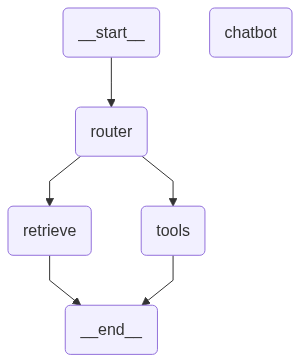

In [ ]:
graph_builder = StateGraph(State)
# graph_builder.add_conditional_edges("retrieve", tools_condition)
graph_builder.add_node("retrieve", retrieve_node)
graph_builder.add_node("router", router_node)
graph_builder.add_node("chatbot", chatbot_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge(START, "router")
graph_builder.add_edge("router", "retrieve")
# graph_builder.add_edge("retrieve", "chatbot")
graph_builder.add_edge("router", "tools")
# graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("retrieve", END)
graph_builder.add_edge("tools", END)

graph = graph_builder.compile()

# graph_builder.add_node("router", router_node)
# graph_builder.add_node("tools", tool_node)
# # graph_builder.add_node("verifier", verifier_node)
# graph_builder.add_node("retrieve", retrieve_node)
# graph_builder.add_node("chatbot", chatbot_node)

# # --- automatic split based on whether router returned a function_call ---
# graph_builder.add_conditional_edges("router", tools_condition)

# # Edge if NO tool call (plain text)  router → retrieve
# graph_builder.add_edge("router", "retrieve")

# # Standard edges
# graph_builder.add_edge(START, "router")
# graph_builder.add_edge("tools", "chatbot")
# # graph_builder.add_edge("verifier", END)
# graph_builder.add_edge("retrieve", "chatbot")
# graph_builder.add_edge("chatbot", END)

# Entry point
# graph_builder.set_entry_point("router")

graph = graph_builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:

output= graph.invoke({"messages": [HumanMessage(content="How do I login to the system?")]})
print(output["messages"][-1].content)

In [153]:

output= graph.invoke({"messages": [HumanMessage(content="Multiply 3 and 2")]})
print(output["messages"][-1].content)

Chatbot node is calling


KeyError: 'context'